### Anomaly detection methods for demand data

There are 3 methods developed here. After comparisons, it was decided that Method 3 is the best one for anomalies similar to one observed in Colorado data in Dec 2016. These December anomalies occurred when there is nothing in the temperature data to suggest the steep changes in demand. Since the anomalies occured near midnight local time, the hypothesis is that they are computer update related.

#### Method 1
Define an anomaly as a demand value whose zscore > threshold. Replace the anomalous value by the seasonal day-hour mean value.

#### Method 2
Define an anomaly as a demand value whose slope_zscore > threshold. Replace the anomalous value by the seasonal day-hour mean value.

#### Method 3
Define an anomaly as a demand value whose slope_zscore > threshold. Replace the anomalous value by linearly interpolating between the flanking non-anomalous values.

#### Implementation Details
Seasons are defined as follows; this was done because data are by full year, so assume no access to pre-January winter data. This also means that the number of samples per day-hour may be different for different seasons

* Winter: Jan 1 -March 31
* Spring: April 1 - June 30
* Summer: July 1 - September 30
* Fall: October 1- Dec 31

These seasonal data are calculated per balancing authority, as they are location dependent.

Note dayofweek in python
* 0 Mon
* 1 Tue
* 2 Wed
* 3 Thurs
* 4 Fri
* 5 Sat
* 6 Sun

Procedure for each BA:
* Check that BA data is not 100% NA, i.e., some BAs do not submit demand data, so do procedure only for those BAs that submit data
* If using Method 1 or 2, generate the mean/SD for the season-dayofweek-hour
* For each demand value (which is indexed by date-time)
* Check what season it belongs to, apply outlier detection and replacement.

Test for some known real weather extremes and make sure those are not replaced.

#### Comparison
For 2016 data, there were 3 sets of anomalies for BA PSCO data, including the previously observed December anomalies.  Using threshold = 3, Method 1 found only 1/3 anomaly sets. Method 2 found all anomalies, but the replacement underestimates the likely demand value. Method 3 found all anomalies, the replacement shows a smoother demand change.

#### Only the best method is shown here.

#### To do
The best method, Method 3, assumes the anomalies are not genuinely demand related and are more likely due to hardware, software, or human errors, and that the demand slope distribution is Gaussian. As other types of anomalies are found, adjustments to the detection criteria may need to be done, depending on the statistical characteristics of the new types of anomalies.

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.parser import parse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import os
import sys
sys.path.append("..")

import find_fix_outliers

In [2]:
#Data dirs
datadir = 'your data dir'
BA = pd.read_csv(datadir + "/" + 'BA_2016.csv', index_col='UTC Time', parse_dates=True )

Create files for calculating seasonal day-hour averages, used for Methods 1 and 2.

In [3]:
winter_index = pd.date_range('2016-01-01 00:00:00','2016-03-31 23:00:00', freq='1H')
spring_index = pd.date_range('2016-04-01 00:00:00','2016-06-30 23:00:00', freq='1H')
summer_index = pd.date_range('2016-07-01 00:00:00','2016-09-30 23:00:00', freq='1H')
fall_index = pd.date_range('2016-10-01 00:00:00','2016-12-31 23:00:00', freq='1H')

winter = BA.loc[winter_index]
spring = BA.loc[spring_index]
summer = BA.loc[summer_index]
fall = BA.loc[fall_index]

winter['weekday_hour'] = winter.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
spring['weekday_hour'] = spring.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
summer['weekday_hour'] = summer.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
fall['weekday_hour'] = fall.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))

winter_weekday_hour_mean = winter.groupby('weekday_hour').mean()
winter_weekday_hour_std = winter.groupby('weekday_hour').std()
spring_weekday_hour_mean = spring.groupby('weekday_hour').mean()
spring_weekday_hour_std = spring.groupby('weekday_hour').std()
summer_weekday_hour_mean = summer.groupby('weekday_hour').mean()
summer_weekday_hour_std = summer.groupby('weekday_hour').std()
fall_weekday_hour_mean = fall.groupby('weekday_hour').mean()
fall_weekday_hour_std = fall.groupby('weekday_hour').std()


Apply methods to Fall 2016 data

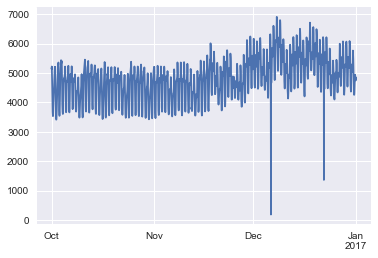

In [4]:
fall['PSCO'].plot()

In [5]:
orig_fall = fall[['PSCO','weekday_hour']]
orig_fall2 = BA['PSCO'].to_frame().copy()

#### Outlier detector and replacement method implementation

In [6]:
fixed_fall_m3 = find_fix_outliers.slope_interpolate(orig_fall2, 3)

5321 5679.0 5679.0
5322 11499.0 6342.0
5323 7005.0 7005.0
8165 5719.0 5719.0
8166 1360.0 5400.333333333333
8167 186.0 5081.666666666667
8168 4763.0 4763.0
8550 5205.0 5205.0
8551 1363.0 4921.0
8552 4637.0 4637.0


In [7]:
print(len(fixed_fall_m3.loc[fixed_fall_m3['delta_zscore']>3]))

7


In [8]:
fixed_fall_m3.rename(columns ={'PSCO':'PSCO3','ba_mean':'ba_mean3'}, inplace = True)

In [9]:
combine_fall = pd.concat([orig_fall, fixed_fall_m3], axis = 1)

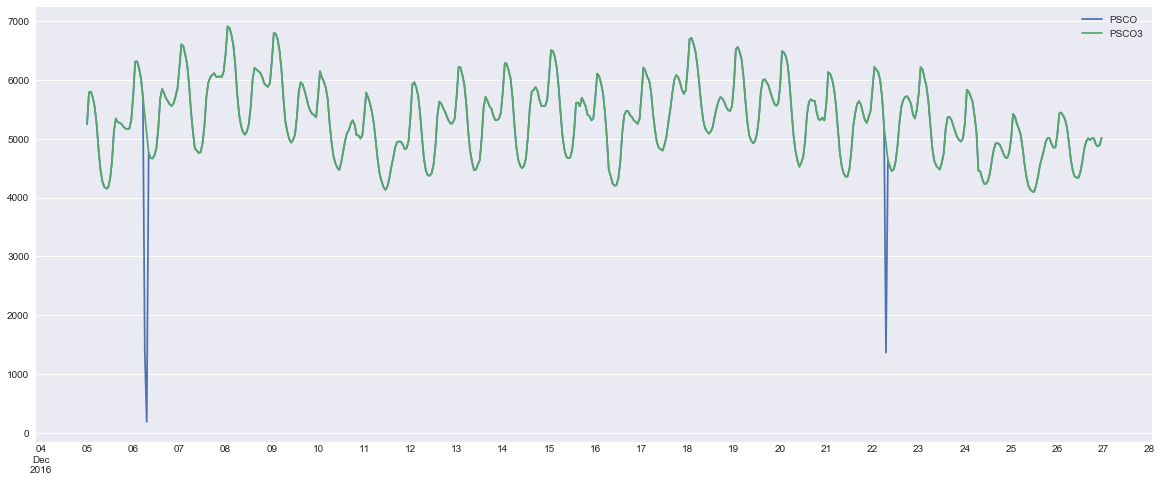

In [10]:
combine_fall.loc['2016-12-05':'2016-12-26'][['PSCO','PSCO3']].plot(figsize=[20,8])

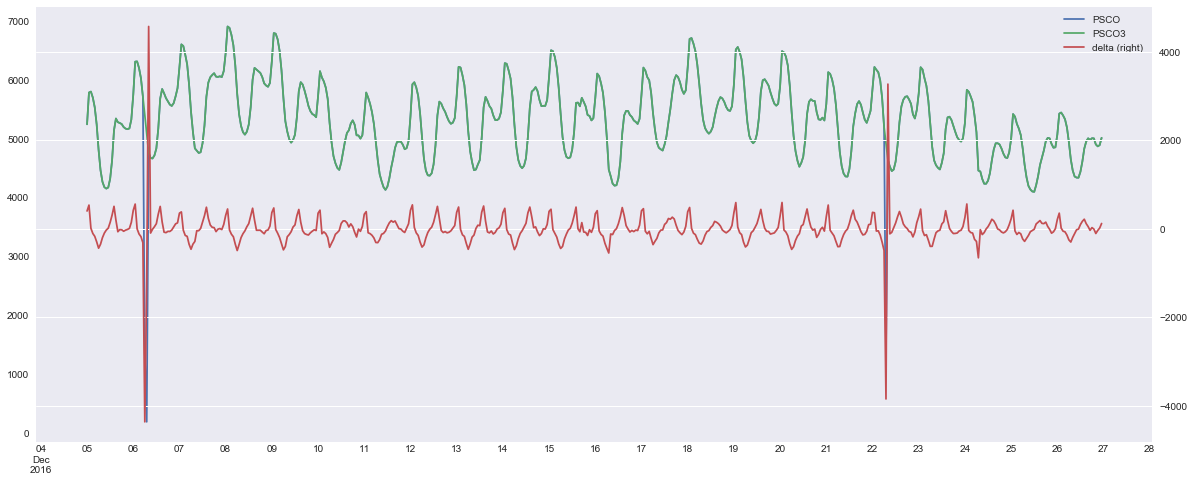

In [11]:
combine_fall.loc['2016-12-05':'2016-12-26'][['PSCO','PSCO3','delta']].plot(figsize=[20,8], secondary_y='delta')

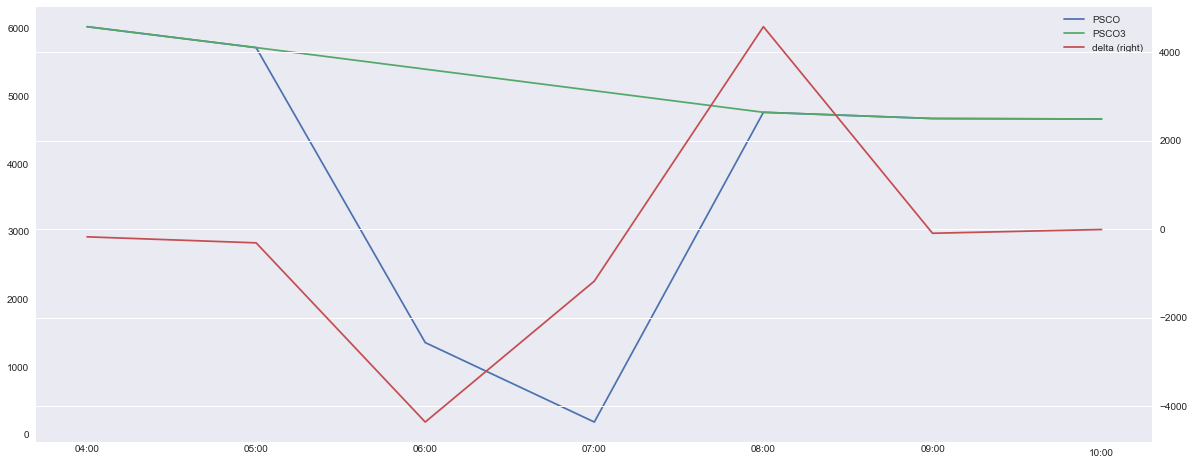

In [12]:
combine_fall.loc['2016-12-06 04:00:00':'2016-12-06 10:00:00'][['PSCO','PSCO3','delta']].plot(figsize=[20,8], secondary_y='delta')

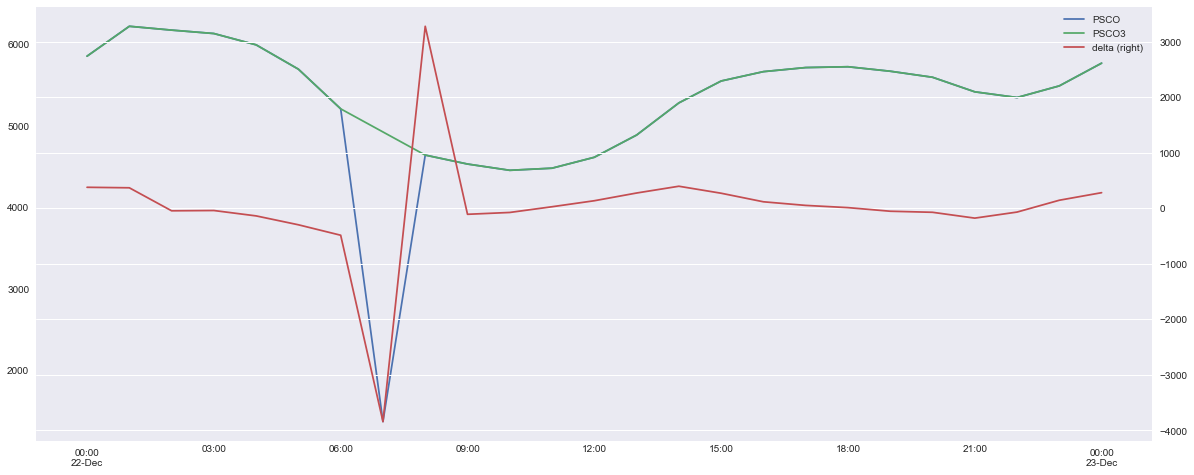

In [13]:
combine_fall.loc['2016-12-22 00:00:00':'2016-12-23 00:00:00'][['PSCO','PSCO3','delta']].plot(figsize=[20,8], secondary_y='delta')